In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from math import pi
import pprint

In [4]:
X, y = load_iris(return_X_y=True)
class_names = load_iris().target_names

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [6]:
classes, counts = np.unique(y_train, return_counts=True)
priors = {c: counts[i] / len(y_train) for i, c in enumerate(classes)}

In [7]:
eps = 1e-9  # to prevent division by zero
means = {}
vars_ = {}
for c in classes:
    X_c = X_train[y_train == c]
    means[c] = X_c.mean(axis=0)
    vars_[c] = X_c.var(axis=0) + eps

In [8]:
def log_likelihood(x, c):
    mu = means[c]
    var = vars_[c]
    term1 = -0.5 * np.sum(np.log(2 * pi * var))
    term2 = -0.5 * np.sum(((x - mu) ** 2) / var)
    return term1 + term2

In [9]:
def predict(X):
    preds = []
    for x in X:
        scores = []
        for c in classes:
            score = np.log(priors[c]) + log_likelihood(x, c)
            scores.append(score)
        preds.append(classes[np.argmax(scores)])
    return np.array(preds)

In [10]:
y_pred = predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [11]:
print("Manual Gaussian Naive Bayes (log-probabilities) Results")
print("-----------------------------------------------------")
print(f"Accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Manual Gaussian Naive Bayes (log-probabilities) Results
-----------------------------------------------------
Accuracy: 0.9111

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Confusion matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


The comparison of the above manual method with built - in Bayesian Decision Theory

In [12]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_sklearn = gnb.predict(X_test)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

In [13]:
print("\nLearned priors:")
pprint.pprint(priors)
print("\nLearned means (per class):")
pprint.pprint(means)
print("\nLearned variances (per class):")
pprint.pprint(vars_)


Learned priors:
{np.int64(0): np.float64(0.3333333333333333),
 np.int64(1): np.float64(0.3333333333333333),
 np.int64(2): np.float64(0.3333333333333333)}

Learned means (per class):
{np.int64(0): array([4.98857143, 3.42571429, 1.48571429, 0.24      ]),
 np.int64(1): array([5.94857143, 2.73142857, 4.23714286, 1.30857143]),
 np.int64(2): array([6.68285714, 3.00857143, 5.63142857, 2.06857143])}

Learned variances (per class):
{np.int64(0): array([0.10329796, 0.17391021, 0.02293878, 0.00925714]),
 np.int64(1): array([0.24078367, 0.08558367, 0.21147755, 0.03564082]),
 np.int64(2): array([0.42484898, 0.1173551 , 0.32272653, 0.06386939])}


In [14]:
def predict_proba_like(x):
    log_scores = np.array([np.log(priors[c]) + log_likelihood(x, c) for c in classes])
    log_scores -= np.max(log_scores)  # for numerical stability
    probs = np.exp(log_scores)
    probs /= probs.sum()
    return probs

In [15]:
print("\nSample test predictions (first 5 test samples):")
for i in range(min(5, X_test.shape[0])):
    probs = predict_proba_like(X_test[i])
    print(f"True: {class_names[y_test[i]]}, Pred: {class_names[y_pred[i]]}, Probs: {np.round(probs, 4)}")


Sample test predictions (first 5 test samples):
True: virginica, Pred: virginica, Probs: [0. 0. 1.]
True: versicolor, Pred: versicolor, Probs: [0.     0.9955 0.0045]
True: virginica, Pred: versicolor, Probs: [0.     0.8472 0.1528]
True: versicolor, Pred: versicolor, Probs: [0.    0.668 0.332]
True: virginica, Pred: virginica, Probs: [0.     0.1036 0.8964]


Classifying MNIST Dataset unsing Logistic Regression

In [16]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt

In [17]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

In [18]:
y_binary = (y == 0).astype(int)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [22]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

In [23]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

In [24]:
print("Binary Classifier (0 vs Not 0) Performance on MNIST")
print("--------------------------------------------------")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Binary Classifier (0 vs Not 0) Performance on MNIST
--------------------------------------------------
Accuracy:  0.9916
Precision: 0.9580
Recall:    0.9573
F1-score:  0.9576
ROC-AUC:   0.9982

Confusion Matrix:
[[12561    58]
 [   59  1322]]


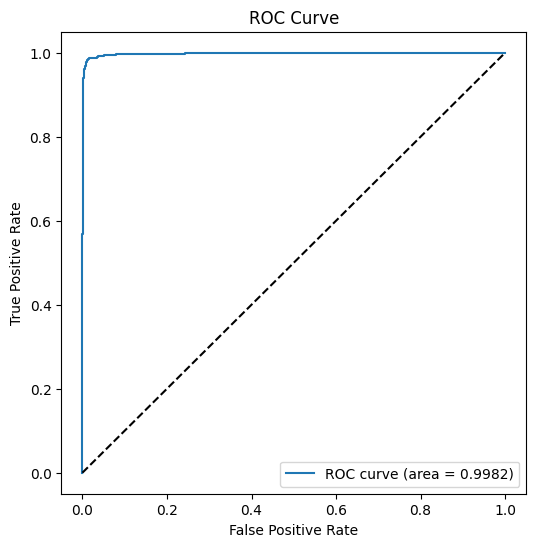

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()